In [1]:
import pandas as pd
import re
import numpy as np
import os

bp_window = 201
df = pd.read_csv("../processed_data/20200918_training.csv.gz")
df = df.dropna()

bp_cols = ["bp_{}".format(i) for i in range(bp_window)]
#remove false negative m6a sequences
df['seqs'] = df[bp_cols].agg(''.join, axis=1)
df = df.sort_values(['seqs','group'], ascending=[True, False])
df = df[~df.duplicated(subset='seqs') | df['group'] == 1]
del df['seqs']

p = re.compile('[ACTG]+')
kmer_cols = [x for x in df.columns if p.match(x)]

phylo_cols = [x for x in df.columns if "phylo" in x]

df_train = df[df["sample"] == "hek293"]

df_test_cd8 = df[df["sample"] == "cd8t"]

df_test_a549 = df[df["sample"] == "a549"]

In [2]:
bp_cat = pd.api.types.CategoricalDtype(categories=['A','C','G','T'],
                                      ordered=False)
def preprocessCNN(df_in):
    "For df with n rows, create 5 x 201 x n matrix encoding bp and phyloP"
    "Return matrix (X) and labels (Y)"
    df = df_in.copy(deep=True)
    n, _ = df.shape
    df[bp_cols] = df[bp_cols].astype(bp_cat)
    for col in bp_cols:
        df[col] = df[col].cat.codes
        
    X = np.zeros((n, bp_window, 5))
    
    for i, row in enumerate(df[bp_cols + phylo_cols].itertuples(index=False)):
        for j in range(bp_window):
            bp = row[j]
            phylo = row[j + bp_window]  # phyloP range is -20 - 9.873 for hg19
            X[i, j, bp] = 1
            X[i, j, 4] = phylo
            
    y = df['group'].values
    
    return X, y

In [3]:
X_train, y_train = preprocessCNN(df_train)

X_test_cd8, y_test_cd8 = preprocessCNN(df_test_cd8)
X_test_a549, y_test_a549 = preprocessCNN(df_test_a549)

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(2132434)
np.random.seed(4345354)
RANDOM_SEED=4383

def build_model(hp):
    model = keras.Sequential()
    i = 0
    model.add(layers.BatchNormalization(input_shape=(bp_window, 5)))
    model.add(layers.Conv1D(filters=hp.Choice('filters_{}'.format(i),
                                             [32,64,128,256]),
                           kernel_size=hp.Choice('kernel_{}'.format(i),
                                                [8,16,32,64])))
    model.add(layers.LeakyReLU())
    if hp.Boolean('add_pool_{}'.format(i)):
        model.add(layers.MaxPooling1D(pool_size=2))
        
    for i in range(1, hp.Int('num_conv_layers', 2, 4)):
        model.add(layers.BatchNormalization())
        model.add(layers.Conv1D(filters=hp.Choice('filters_{}'.format(i),
                                                 [32,64,128,256]),
                               kernel_size=hp.Choice('kernel_{}'.format(i),
                                                    [4,8,16])))
        model.add(layers.LeakyReLU())
        if hp.Boolean('add_pool_{}'.format(i)):
            model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.Flatten())
    
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(layers.Dense(hp.Choice('dense_{}'.format(i),
                                        [32,64,128]), activation='relu'))
        model.add(layers.Dropout(hp.Float('dropout_{}'.format(i), 0.1, 0.5, step=0.1)))
        
    model.add(layers.Dense(1, activation="sigmoid"))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    
    return model

In [5]:
from kerastuner.tuners import Hyperband

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=25,
    factor=3,
    hyperband_iterations=2,
    directory=os.path.normpath('E:/'),
    project_name='m6a_cnn_tuner_hyperband',
    seed=RANDOM_SEED,
    overwrite=True
)

tuner.search_space_summary()

In [6]:
import IPython 

class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [7]:
history = tuner.search(X_train, y_train,
            epochs=25,
            validation_data=(X_test_cd8, y_test_cd8), verbose=0, callbacks=[ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [8]:
tuner.results_summary()

In [10]:
model_final = build_model(tuner.get_best_hyperparameters(num_trials=1)[0])

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor="val_loss", mode='min', verbose=1,
                  patience=20)
mc = ModelCheckpoint(
    filepath='cnn.kt.hb.tf',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
history = model_final.fit(X_train, y_train,
                   validation_data=(X_test_cd8, y_test_cd8),
                   epochs=1000, verbose=0, callbacks=[es, mc])

INFO:tensorflow:Assets written to: cnn.kt.hb.tf\assets
INFO:tensorflow:Assets written to: cnn.kt.hb.tf\assets
INFO:tensorflow:Assets written to: cnn.kt.hb.tf\assets
INFO:tensorflow:Assets written to: cnn.kt.hb.tf\assets
INFO:tensorflow:Assets written to: cnn.kt.hb.tf\assets
Epoch 00024: early stopping


In [5]:
saved_model = keras.models.load_model('cnn.kt.hb.tf')

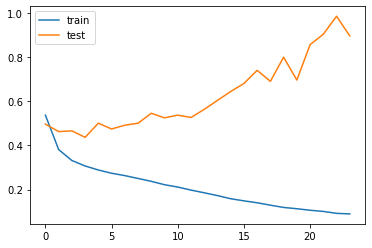

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [14]:
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test_cd8, y_test_cd8, verbose=0)

print('Train: {:.3f}, Test: {:.3f}'.format(train_acc, test_acc))

Train: 0.945, Test: 0.802


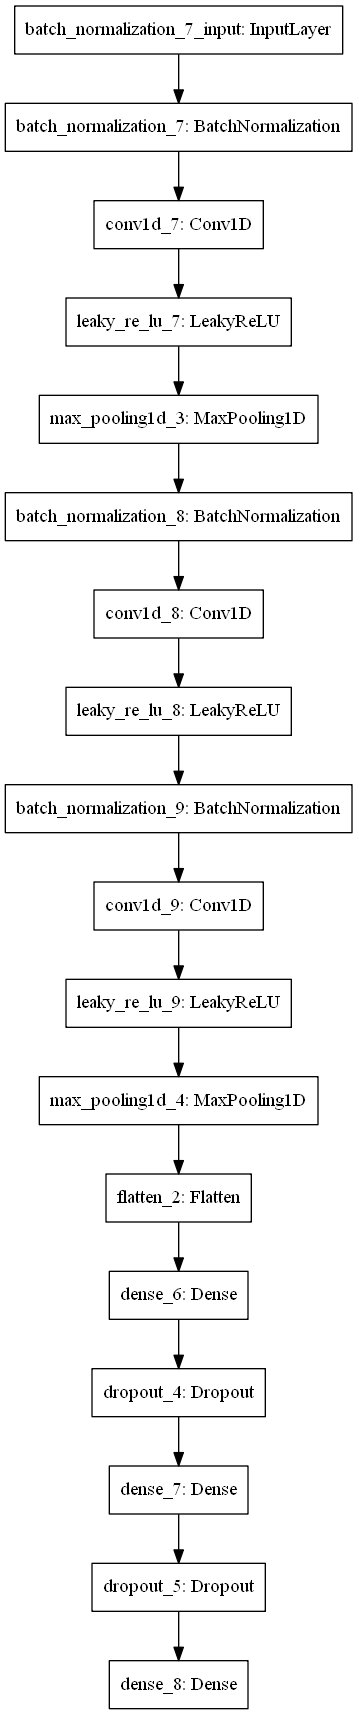

In [15]:
keras.utils.plot_model(saved_model, show_shapes=False)

In [6]:
saved_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 201, 5)            20        
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 194, 256)          10496     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 194, 256)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 97, 256)           0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 97, 256)           1024      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 90, 32)            65568     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 90, 32)           

In [7]:
cnn_1_model = keras.Model(saved_model.input,
                         saved_model.get_layer("conv1d_7").output)
cnn_1 = cnn_1_model.predict(X_train)

In [8]:
filter_subs = np.zeros((cnn_1.shape[0], cnn_1.shape[2] * 2))

for i in range(cnn_1.shape[0]):
    for j in range(cnn_1.shape[2]):
        filter_subs[i, 2*j] = np.amax(cnn_1[i,:,j])
        filter_subs[i, 2 * j + 1] = np.argmax(cnn_1[i,:,j])

filter_sub_cols = ["subseq_{}".format(i // 2) if i % 2
                   else "weight_{}".format(i // 2)
                   for i in range(cnn_1.shape[2] * 2)]
df_filter_subs = pd.DataFrame(data=filter_subs, columns=filter_sub_cols)

In [9]:
df_filter_subs["group"] = df_train["group"].values
df_filter_subs["seq"] = df[df["sample"] == "hek293"][bp_cols].agg(''.join, axis=1).values

from Bio import motifs
from Bio.Seq import Seq

kernel_size=8

def getMotifs(df):
    motif_list = {}

    for i in range(cnn_1.shape[2]):
        seqs = []
        subseq = "subseq_{}".format(i)
        weights = (df["weight_{}".format(i)] * 10).astype(int).values
        subseqs = []
        for row in df[[subseq, "seq"]].itertuples(index=False):
            max_subseq = str(row[1])
            idx = int(row[0])
            subseqs += [max_subseq[idx:(idx + kernel_size)]]
            
        for seq, weight in zip(subseqs, weights):
            for j in range(weight):
                seqs += [Seq(seq)]

        motif_list[i] = motifs.create(seqs)
    
    return motif_list

m6a_motifs = getMotifs(df_filter_subs[df_filter_subs['group'] == 1])

degenerate_motifs = [m6a_motifs[x].degenerate_consensus for x in m6a_motifs.keys()]
pd.Series(degenerate_motifs, name='motifs').to_csv('../processed_data/cnn_filters.csv', index=False)

In [24]:
with open('../processed_data/cnn_filters.meme', 'w') as outmeme:
    outmeme.write('MEME version 5\n')
    outmeme.write('ALPHABET= ACGT\n')
    outmeme.write('strands: + -\n')
    outmeme.write('Background letter frequencies (from web form):\nA 0.25000 C 0.25000 G 0.25000 T 0.25000\n')
    for i, motif_key in enumerate(m6a_motifs.keys()):
        outmeme.write('MOTIF CNN_FILTER_{} CNN_FILTER_{}\n\n'.format(i,i))
        outmeme.write('letter-probability matrix: alength= 4 w= {}\n'.format(kernel_size))
        motif = m6a_motifs[motif_key]
        df_nt_counts = pd.DataFrame(motif.counts)
        df_nt_counts = df_nt_counts.div(df_nt_counts.sum(axis=1), axis=0)
        df_nt_counts.to_csv(outmeme, sep='\t', header=False, index=False, line_terminator='\n')
        outmeme.write('\n')